In [1]:
# -*- coding: utf-8 -*-
"""
This is a workflow intended to expedite the plotting of flow properties from CenCOOS 2km HF Radar Data
Optimized to run on Eady (eady.caltech.edu)

Please utilize the Dask distributed Client scheduler for best results
Last Updatedd 06/18/2020 Thursday

"""
from IPython.core.display import display, HTML # Widen jupyter notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
# Setup Distributed Client
autostart = True
if autostart:
    pass # just let it use the dask lab extension cluster
else:
    from dask.diagnostics import ProgressBar
    from dask.distributed import Client
    from dask.distributed import LocalCluster
    # client = Client('localhost:8787') # Connect to old dashboard?
    try:
        client = Client('tcp://localhost:8786', timeout='2s')
    except OSError:
        cluster = LocalCluster(scheduler_port=8786)
        client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46636 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.93 GB


In [3]:
#%% Setup Packages
import xarray as xr
from xarray import open_mfdataset
import dask
import dask.array as da
import netCDF4 as netcdf
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams, cycler
from matplotlib.animation import FuncAnimation
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units
import itertools
import scipy.spatial
import sklearn.metrics
from fractions import Fraction
import warnings
import dateutil
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from scipy.signal import argrelextrema



import sys
import os
from importlib import reload

sys.path.insert(1,r"/export/home1/jbenjami/Research_Thompson/Python/personal/")
print(sys.path)
import personal

import personal.math as pm
import personal.data_structures
import personal.date_operations
import personal.SMODE
import personal.calculations
import personal.geometry
import personal.system
import personal.plots
import personal.IO
import personal.constants
import personal.geospatial

import gc; gc.collect()

a                = personal.constants.earth['radius']
seasons          = {'DJF':[12, 1, 2],'JFM':[ 1, 2, 3],'FMA':[ 2, 3, 4],
                    'MAM':[ 3, 4, 5],'AMJ':[ 4, 5, 6],'MJJ':[ 5, 6, 7],
                    'JJA':[ 6, 7, 8],'JAS':[ 7, 8, 9],'ASO':[ 8, 9,10],
                    'SON':[ 9,10,11],'OND':[10,11,12],'NDJ':[11,12, 1]}
file_path        = os.path.abspath(os.path.dirname(''))
data_relpath     = "../Data/LLC4320/smode_region/"
output_savepath  = "../Data/LLC4320/smode_region/miscellaneous/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath))

# Load kinetic_energy from regular location
# time_chunk        = 24*7*14

# metadata          = xr.open_mfdataset(data_source +'/*.h5', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override") # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
#%% Plot setup
dpi = 100
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from matplotlib import animation, rcParams, cycler
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

['/export/home1/jbenjami/Research_Thompson/Python', '/export/home1/jbenjami/Research_Thompson/Python/personal/', '/export/home1/jbenjami/anaconda3/lib/python37.zip', '/export/home1/jbenjami/anaconda3/lib/python3.7', '/export/home1/jbenjami/anaconda3/lib/python3.7/lib-dynload', '', '/export/home1/jbenjami/.local/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/export/home1/jbenjami/.ipython']


In [4]:
#Load data, pure velocity Not needed bc we can just use baseline="" from the primed velocities u_p, v_p
kinetic_energy              = xr.open_mfdataset(data_source+'/kinetic_energy/*.nc*'          , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
kinetic_energy              = personal.data_structures.assign_x_y_to_lat_lon_dataset(kinetic_energy, {'t':0,'y':1,'x':2})
kinetic_energy_smoothed     = xr.open_mfdataset(data_source+'/smoothed//kinetic_energy/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
kinetic_energy_smoothed     = personal.data_structures.assign_x_y_to_lat_lon_dataset(kinetic_energy_smoothed, {'t':0,'y':1,'x':2})

lat, lon, latg, long, time  = kinetic_energy['lat'], kinetic_energy['lon'], kinetic_energy['latg'], kinetic_energy['long'], kinetic_energy['time']
coords                      = np.float32(np.stack((latg.values.flatten(), long.values.flatten()),axis=1)) # check order (x,y matches lon,lat)

seas_groups                 = {seas:time.dt.month.isin(months) for seas,months in seasons.items()}
mn_groups                   = {month:time.dt.month.isin(month) for month in np.unique(time.dt.month)}
t_str =  time.dt.strftime("%Y-%m")
yrmn_groups                 = {x: t_str.isin(x) for x in np.unique(t_str)}

In [22]:
speed_sf          = personal.SMODE.calculate_structure_fcn(
    data                    = kinetic_energy['speed'].sel(baseline=""),
    precomputed             = {},
    save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
    save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_speed_sf.pkl',
    file_path               = os.path.abspath(os.path.dirname('')),
    data_relpath            = "../Data/LLC4320/",
    output_savepath         = "../Data/LLC4320/smode_region/miscellaneous/",
    metadata                = velocity,
    random_subset_size      = 10000,
    time_groups             = {'all':slice(0,None,None)}, # how to group the time, can be a list of logical arrays
    nbins                   = 50,
    order                   = 2,
    fill_output_na          = False,
    vectorize               = True,
    parallelize             = True,
    parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
    progress_bar            = True,
    ch_size_fcn             = lambda x: 50000,
    value_fcn_parallelize   = True,
    value_fcn_parallel_args = None,
    value_fcn_progress_bar  = True )
_ = gc.collect()

NameError: name 'velocity' is not defined

In [73]:
# domain so big here, clustering is more likely to work (and reduce the problem of bad resolution at the small scales and large subsets required for convergence...)... but time is smaller so we can afford to use more data anyway
n = 8000 * 2 # want ~ 5000 points after filtering, assume ~ 1/2 are likely to be nan
L = round(n**(1./2))
ratios = np.array([len(KE['lat']), len(KE['lon'])])
ratios = ratios / np.prod(ratios)**(1./2)
Ls     = np.round(ratios*L).astype(int)
clustered_lats = KE['lat'][pm.random_with_clustering(nmax = len(KE.lat), L = Ls[0], mean_cluster_size=5,safety_counter_max=100)]
clustered_lons = KE['lon'][pm.random_with_clustering(nmax = len(KE.lon), L = Ls[1], mean_cluster_size=5,safety_counter_max=100)]

In [74]:
warnings.filterwarnings('ignore');
KE_baseline_all_eddy_KE_sf  = personal.SMODE.calculate_structure_fcn(
#     data                    = kinetic_energy['KE'].sel(baseline="all"),
    data           = KE['KE'].sel(baseline="all",lat=clustered_lats,lon=clustered_lons),
    precomputed             = {},
    save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
    save_filepath  = None,
#     save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_baseline_all_eddy_KE_sf.pkl',
    file_path               = os.path.abspath(os.path.dirname('')),
    data_relpath            = "../Data/LLC4320/",
    output_savepath         = "../Data/LLC4320/miscellaneous/velocity/",
    metadata                = None,
#     random_subset_size      = 5000,
    random_subset_size      = None,

    time_groups             = {'all':slice(0,None,None)}, # how to group the time, can be a list of logical arrays
    nbins                   = 50,
    order                   = 2,
    fill_output_na          = False,
    vectorize               = True,
    parallelize             = True,
    parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
    progress_bar            = True,
    ch_size_fcn             = lambda x: 20000,
    value_fcn_parallelize   = True,
    value_fcn_parallel_args = None,
    value_fcn_progress_bar  = True )
_ = gc.collect()

precomputing...
getting values from DataArray
Done
transposing
reshaping
calculating coordinates
data valid subset is of length:  13042
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 20000 for total length 85040361 -> 4253.0 chunks
{'n_jobs': 20}


parallelizing



(1500.0, 5000.0)

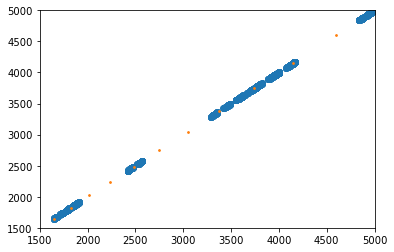

In [72]:
# Clustering quick check
y = np.sort(np.unique(KE_baseline_all_eddy_KE_sf['distances']))
x = np.arange(len(y))
y2 = KE_baseline_all_eddy_KE_sf['distance_bins']
x2 = np.arange(len(y2))
plt.scatter(y,y)
plt.scatter(y2,y2,3)
lim = [1500, 5000]
plt.xlim(lim)
plt.ylim(lim)

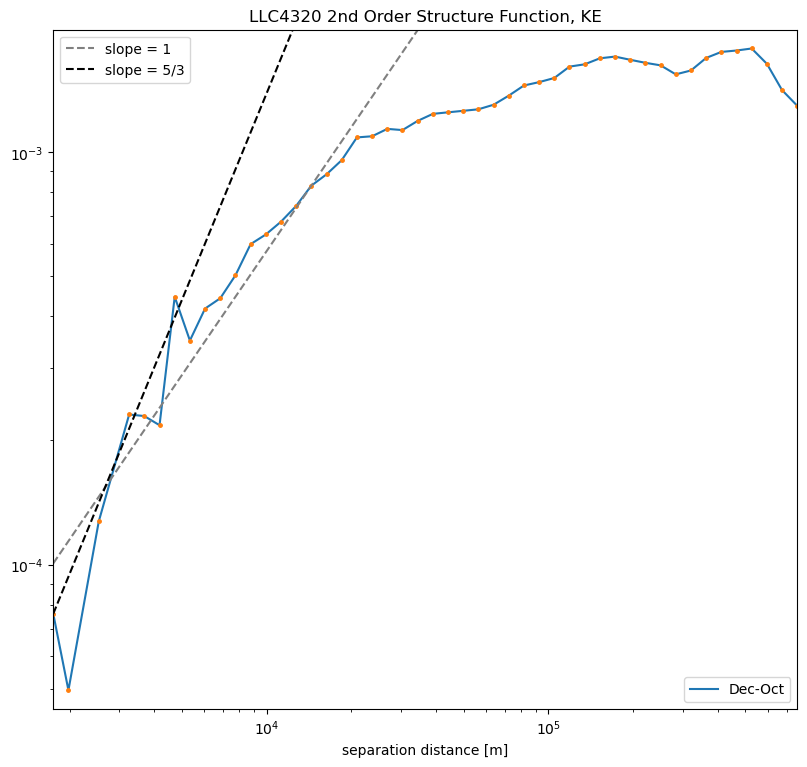

In [75]:
m = KE_baseline_all_eddy_KE_sf['structure_fcn']['all']
# m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_baseline_all_eddy_KE_sf.pkl')['structure_fcn']['all']
# m = m.dropna()
_=gc.collect()
reload(personal.plots)
fig = personal.plots.default_figure()
m = m.dropna()
_ax = m.plot(logx=True,logy=True,ylim=[np.nanmin(m.values[:]),np.nanmax(m.values[:])]*np.array([.9,1/.9]),label='Dec-Oct')
m.plot(ax=_ax,logx=True,logy=True,label='_nolegend_',style='.', markersize=5)

_ax.set_xlim(np.array([m.index[0],m.index[-1]]))
_ax.set_xlabel('separation distance [m]')
_ax.set_title('LLC4320 2nd Order Structure Function, KE')

slope = Fraction(1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[15] ,m.values[15]]  ,color='gray'   ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction(5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[0] ,m.values[0]]  ,color='k',linestyle='--',label='slope = ' + str(slope))

leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][0:1], leg[1][ 0:1], loc='lower right' , ncol=4)
_    = _ax.legend(leg[0][1:  ], leg[1][1:  ], loc='upper left' , ncol=1)
_    = _ax.add_artist(leg1)

In [89]:
reload(personal.SMODE)
speed_smoothed_sf = personal.SMODE.calculate_structure_fcn(data                    = velocity_smoothed['speed'],
                                                           precomputed             = {},
                                                           save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
                                                           save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_speed_smoothed_sf.pkl',
                                                           file_path               = os.path.abspath(os.path.dirname('')),
                                                           data_relpath            = "../Data/LLC4320",
                                                           output_savepath         = "../Data/LLC4320/miscellaneous",
                                                           metadata                = velocity_smoothed['KE'],
                                                           random_subset_size      = 5000,
                                                           time_groups             = {'all':slice(0,None,None)}, # how to group the time, can be a list of logical arrays
                                                           nbins                   = 50,
                                                           order                   = 2,
                                                           fill_output_na          = False,
                                                           vectorize               = True,
                                                           parallelize             = True,
                                                           parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
                                                           progress_bar            = True,
                                                           ch_size_fcn             = lambda x: 50000,
                                                           value_fcn_parallelize   = True,
                                                           value_fcn_parallel_args = None,
                                                           value_fcn_progress_bar  = True
                                                             )

precomputing...
getting values from DataArray
Done
transposing
reshaping
calculating coordinates
taking data subset
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 50000 for total length 12497500 -> 250.0 chunks
{'n_jobs': 20}


parallelizing



/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:194: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])


saving...


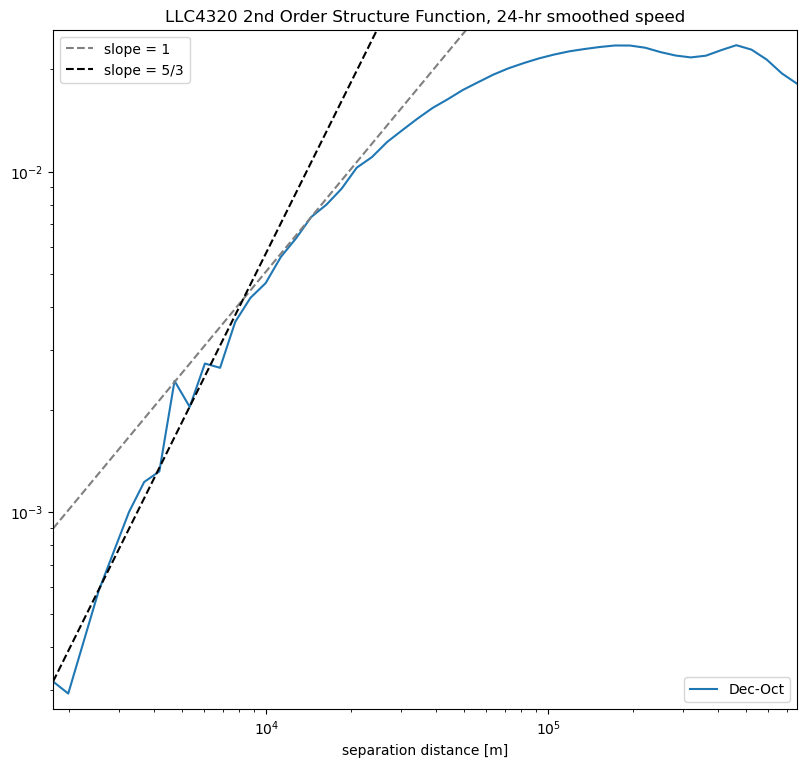

In [107]:
m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_speed_smoothed_sf.pkl')['structure_fcn']['all']
m = m.dropna()
_=gc.collect()
reload(personal.plots)
fig = personal.plots.default_figure()
_ax = m.plot(logx=True,logy=True,ylim=[np.nanmin(m.values[:]),np.nanmax(m.values[:])]*np.array([.9,1/.9]),label='Dec-Oct')
_ax.set_xlim(np.array([m.index[0],m.index[-1]]))
_ax.set_xlabel('separation distance [m]')
_ax.set_title('LLC4320 2nd Order Structure Function, 24-hr smoothed speed')

slope = Fraction(1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[15] ,m.values[15]]  ,color='gray'   ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction(5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[0] ,m.values[0]]  ,color='k',linestyle='--',label='slope = ' + str(slope))

leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][0:1], leg[1][ 0:1], loc='lower right',ncol=4)
_    = _ax.legend(leg[0][1:  ], leg[1][1:  ], loc='upper left' ,ncol=1)
_    = _ax.add_artist(leg1)

In [65]:
reload(personal.SMODE)
KE_sf             = personal.SMODE.calculate_structure_fcn(data                    = velocity['KE'],
                                                           precomputed             = {},
                                                           save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
                                                           save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_sf.pkl',
                                                           file_path               = os.path.abspath(os.path.dirname('')),
                                                           data_relpath            = "../Data/LLC4320",
                                                           output_savepath         = "../Data/LLC4320/miscellaneous",
                                                           metadata                = velocity['KE'],
                                                           random_subset_size      = 5000,
                                                           time_groups             = {'all':slice(0,None,None)}, # how to group the time, can be a list of logical arrays
                                                           nbins                   = 50,
                                                           order                   = 2,
                                                           fill_output_na          = False,
                                                           vectorize               = True,
                                                           parallelize             = True,
                                                           parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
                                                           progress_bar            = True,
                                                           ch_size_fcn             = lambda x: 50000,
                                                           value_fcn_parallelize   = True,
                                                           value_fcn_parallel_args = None,
                                                           value_fcn_progress_bar  = True
                                                             )

precomputing...
getting values from DataArray
Done
transposing
reshaping
(86434, 16790)
(103224, 0)
calculating coordinates
taking data subset
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 30000 for total length 12497500 -> 417.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:194: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...


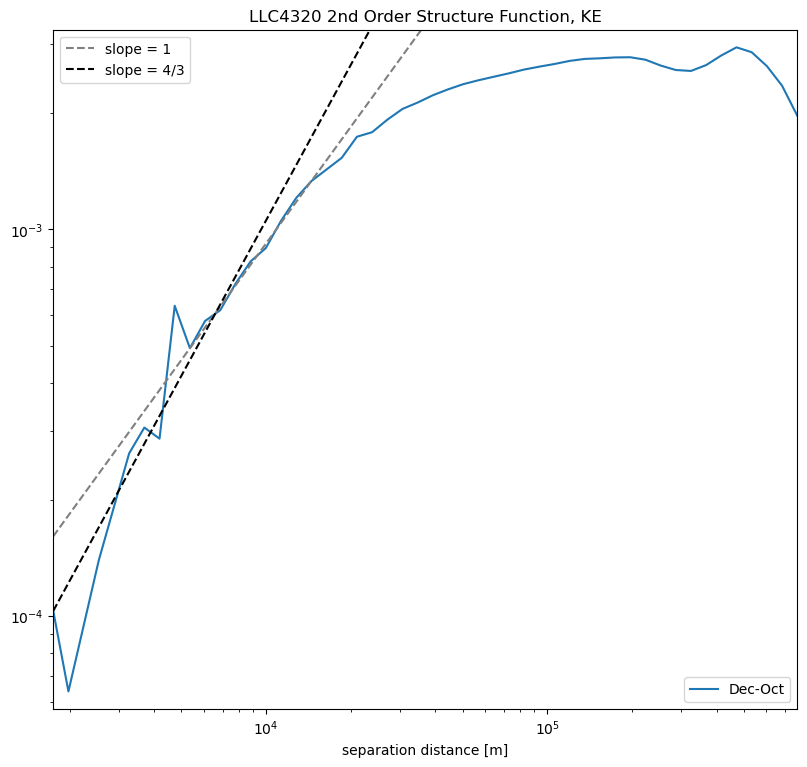

In [17]:
m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_sf.pkl')['structure_fcn']['all']
m = m.dropna()
_=gc.collect()
reload(personal.plots)
fig = personal.plots.default_figure()
_ax = m.plot(logx=True,logy=True,ylim=[np.nanmin(m.values[:]),np.nanmax(m.values[:])]*np.array([.9,1/.9]),label='Dec-Oct')
_ax.set_xlim(np.array([m.index[0],m.index[-1]]))
_ax.set_xlabel('separation distance [m]')
_ax.set_title('LLC4320 2nd Order Structure Function, KE')

slope = Fraction(  1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[15] ,m.values[15]]  ,color='gray' ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction(4,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[ 0] ,m.values[ 0]]  ,color='k'    ,linestyle='--',label='slope = ' + str(slope))

leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][0:1], leg[1][ 0:1], loc='lower right',ncol=4)
_    = _ax.legend(leg[0][1: ], leg[1][1:  ], loc='upper left' ,ncol=1)
_    = _ax.add_artist(leg1)

In [71]:
reload(personal.SMODE)
_ = gc.collect()
KE_rolling_seas_sf             = personal.SMODE.calculate_structure_fcn(data       = velocity['KE'],
                                                           precomputed             = {},
                                                           save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
                                                           save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_rolling_seas_sf.pkl',
                                                           file_path               = os.path.abspath(os.path.dirname('')),
                                                           data_relpath            = "../Data/LLC4320",
                                                           output_savepath         = "../Data/LLC4320/miscellaneous",
                                                           metadata                = velocity['KE'],
                                                           random_subset_size      = 5000,
                                                           time_groups             = time_groups, # how to group the time, can be a list of logical arrays
                                                           nbins                   = 50,
                                                           order                   = 2,
                                                           fill_output_na          = False,
                                                           vectorize               = True,
                                                           parallelize             = True,
                                                           parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
                                                           progress_bar            = True,
                                                           ch_size_fcn             = lambda x: 150000,
#                                                            ch_size_fcn             = None,
                                                           value_fcn_parallelize   = True,
                                                           value_fcn_parallel_args = None,
                                                           value_fcn_progress_bar  = True)

precomputing...
getting values from DataArray
Done
transposing
reshaping
calculating coordinates
taking data subset
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:194: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

saving...


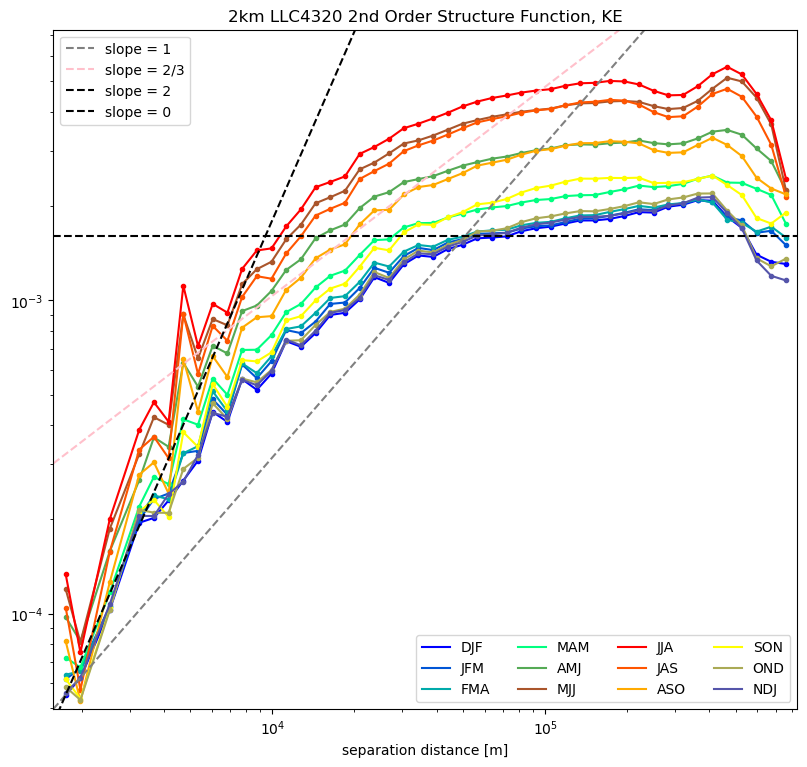

In [34]:
# reload(personal.plots)
m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_rolling_seas_sf.pkl')['structure_fcn'] 
fig = personal.plots.default_figure()
_ax  = plt.axes()
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
for seas, color in zip(m_seas.keys(),colors):
#     m_seas[seas].fillna(method='ffill').plot(ax=_ax,logx=True,logy=True,label=seas,c=color)
    m_seas[seas].dropna().plot(ax=_ax,logx=True,logy=True,label=seas,c=color)
    m_seas[seas].dropna().plot(ax=_ax,logx=True,logy=True,label='_nolegend_',c=color,style='.')

_ax.set_xlim(np.array([m_seas['DJF'].index[0]*0.9 ,m_seas['DJF'].index[-1]*1.1]))
_ax.set_ylim([np.nanmin(m_seas['DJF'].values[:-1]),np.nanmax(m_seas['DJF'].values[:-1]) ]*np.array([.9,3.5]))
_ax.set_xlabel('separation distance [m]')
_ax.set_title('2km LLC4320 2nd Order Structure Function, KE')

slope = Fraction(6,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[0]  ,m_seas['DJF'].values[0]]  ,color='k'   ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction(1,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[0]  ,m_seas['DJF'].values[0]]  ,color='gray',linestyle='--',label='slope = ' + str(slope))
slope = Fraction(2,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['JAS'].index[-20],m_seas['JAS'].values[-20]],color='pink',linestyle='--',label='slope = ' + str(slope))
slope = Fraction(0,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[-20],m_seas['DJF'].values[-20]],color='k'   ,linestyle='--',label='slope = ' + str(slope))
leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='lower right',ncol=4)
_    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper left' ,ncol=1)
_    = _ax.add_artist(leg1)

In [92]:
reload(personal.SMODE)
_ = gc.collect()
KE_smoothed_rolling_seas_sf    = personal.SMODE.calculate_structure_fcn(data       = velocity_smoothed['KE'],
                                                           precomputed             = {},
                                                           save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
                                                           save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_smoothed_rolling_seas_sf.pkl',
                                                           file_path               = os.path.abspath(os.path.dirname('')),
                                                           data_relpath            = "../Data/LLC4320",
                                                           output_savepath         = "../Data/LLC4320/miscellaneous",
                                                           metadata                = velocity_smoothed['KE'],
                                                           random_subset_size      = 5000,
                                                           time_groups             = time_groups, # how to group the time, can be a list of logical arrays
                                                           nbins                   = 50,
                                                           order                   = 2,
                                                           fill_output_na          = False,
                                                           vectorize               = True,
                                                           parallelize             = True,
                                                           parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
                                                           progress_bar            = True,
                                                           ch_size_fcn             = lambda x: 150000,
#                                                            ch_size_fcn             = None,
                                                           value_fcn_parallelize   = True,
                                                           value_fcn_parallel_args = None,
                                                           value_fcn_progress_bar  = True)

precomputing...
getting values from DataArray
Done
transposing
reshaping
calculating coordinates
taking data subset
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:194: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

saving...


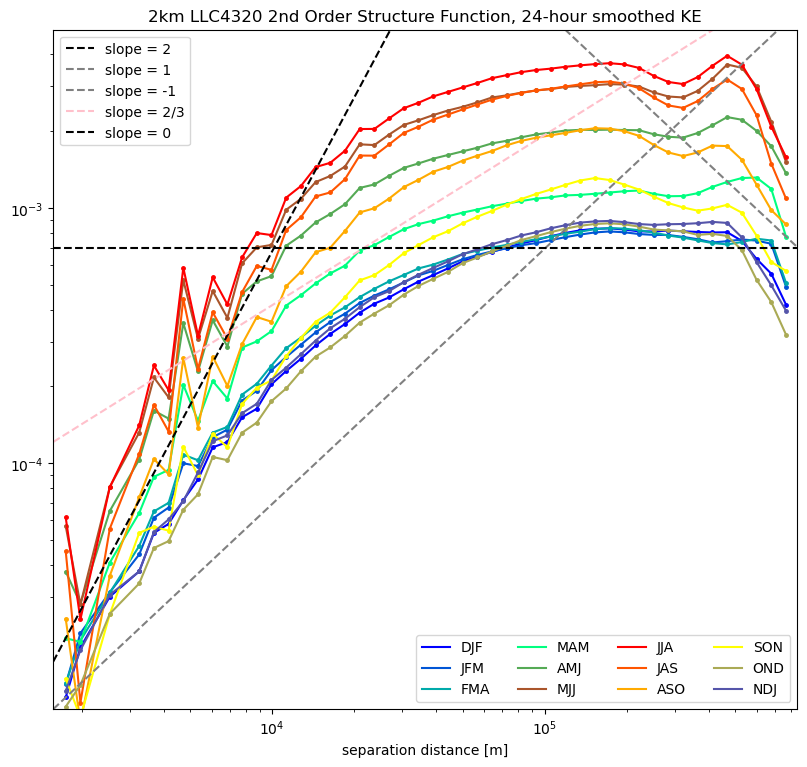

In [38]:
# reload(personal.plots)
m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_smoothed_rolling_seas_sf.pkl')['structure_fcn'] 
fig = personal.plots.default_figure()
_ax  = plt.axes()
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
for seas, color in zip(m_seas.keys(),colors):
#     m_seas[seas].fillna(method='ffill').plot(ax=_ax,logx=True,logy=True,label=seas,c=color)
    m_seas[seas].dropna().plot(ax=_ax,logx=True,logy=True,label=seas,c=color)
    m_seas[seas].plot(ax=_ax,logx=True,logy=True,label='_nolegend_',c=color,style='.', markersize=5)

_ax.set_xlim(np.array([m_seas['DJF'].index[0]*.9 ,m_seas['DJF'].index[-1]*1.1]))
_ax.set_ylim([np.nanmin(m_seas['DJF'].values[:-1]),np.nanmax(m_seas['DJF'].values[:-1]) ]*np.array([.9,6]))
_ax.set_xlabel('separation distance [m]')
_ax.set_title('2km LLC4320 2nd Order Structure Function, 24-hour smoothed KE')

slope = Fraction( 6,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['MAM'].index[0]  ,m_seas['MAM'].values[0]]  ,color='k'   ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction( 1,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[0]  ,m_seas['DJF'].values[0]]  ,color='gray',linestyle='--',label='slope = ' + str(slope))
slope = Fraction(-1,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['MAM'].index[-1] ,m_seas['MAM'].values[-1]] ,color='gray',linestyle='--',label='slope = ' + str(slope))
slope = Fraction( 2,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['MAM'].index[-30],m_seas['MAM'].values[-30]],color='pink',linestyle='--',label='slope = ' + str(slope))
slope = Fraction( 0,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[-20],m_seas['DJF'].values[-20]],color='k'   ,linestyle='--',label='slope = ' + str(slope))
leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='lower right',ncol=4)
_    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper left' ,ncol=1)
_    = _ax.add_artist(leg1)

In [112]:
reload(personal.SMODE)
_ = gc.collect
speed_smoothed_rolling_seas_sf = personal.SMODE.calculate_structure_fcn(data       = velocity_smoothed['speed'],
                                                           precomputed             = {},
                                                           save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
                                                           save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_speed_smoothed_rolling_seas_sf.pkl',
                                                           file_path               = os.path.abspath(os.path.dirname('')),
                                                           data_relpath            = "../Data/LLC4320",
                                                           output_savepath         = "../Data/LLC4320/miscellaneous",
                                                           metadata                = velocity_smoothed['speed'],
                                                           random_subset_size      = 5000,
                                                           time_groups             = time_groups, # how to group the time, can be a list of logical arrays
                                                           nbins                   = 50,
                                                           order                   = 2,
                                                           fill_output_na          = False,
                                                           vectorize               = True,
                                                           parallelize             = True,
                                                           parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
                                                           progress_bar            = True,
                                                           ch_size_fcn             = lambda x: 150000,
#                                                            ch_size_fcn             = None,
                                                           value_fcn_parallelize   = True,
                                                           value_fcn_parallel_args = None,
                                                           value_fcn_progress_bar  = True)

precomputing...
getting values from DataArray
Done
transposing
reshaping
calculating coordinates
taking data subset
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:194: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 150000 for total length 12497500 -> 84.0 chunks
{'n_jobs': 20}


parallelizing

saving...


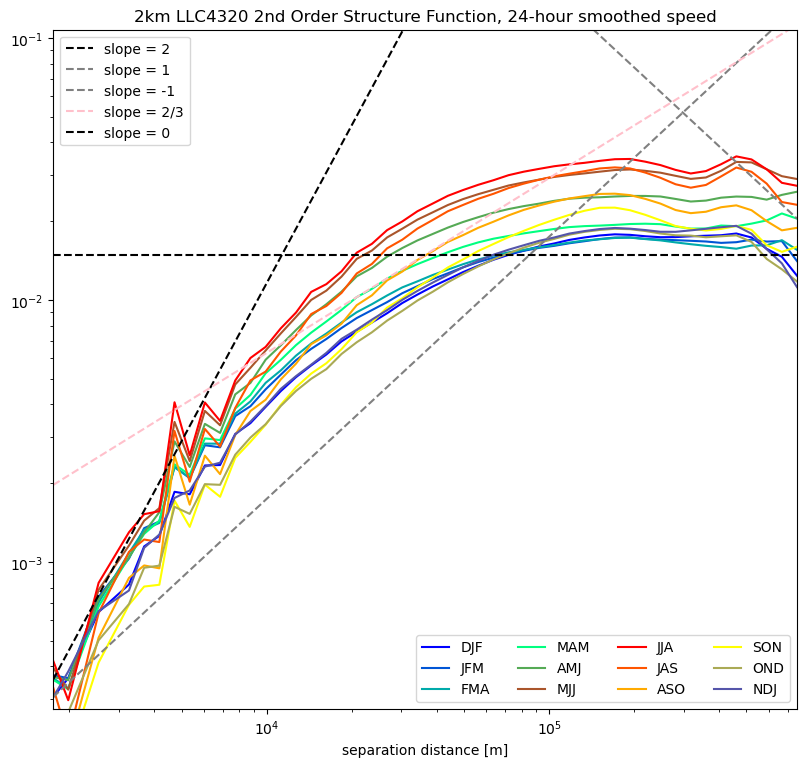

In [127]:
# reload(personal.plots)
m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_speed_smoothed_rolling_seas_sf.pkl')['structure_fcn'] 
fig = personal.plots.default_figure()
_ax  = plt.axes()
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
for seas, color in zip(m_seas.keys(),colors):
#     m_seas[seas].fillna(method='ffill').plot(ax=_ax,logx=True,logy=True,label=seas,c=color)
    m_seas[seas].dropna().plot(ax=_ax,logx=True,logy=True,label=seas,c=color)
_ax.set_xlim(np.array([m_seas['DJF'].index[0] ,m_seas['DJF'].index[-1]]))
_ax.set_ylim([np.nanmin(m_seas['DJF'].values[:-1]),np.nanmax(m_seas['DJF'].values[:-1]) ]*np.array([.9,6]))
_ax.set_xlabel('separation distance [m]')
_ax.set_title('2km LLC4320 2nd Order Structure Function, 24-hour smoothed speed')

slope = Fraction( 6,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['MAM'].index[0]  ,m_seas['MAM'].values[0]]  ,color='k'   ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction( 1,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[0]  ,m_seas['DJF'].values[0]]  ,color='gray',linestyle='--',label='slope = ' + str(slope))
slope = Fraction(-1,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['MAM'].index[-1] ,m_seas['MAM'].values[-1]] ,color='gray',linestyle='--',label='slope = ' + str(slope))
slope = Fraction( 2,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['MAM'].index[-30],m_seas['MAM'].values[-30]],color='pink',linestyle='--',label='slope = ' + str(slope))
slope = Fraction( 0,1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m_seas['DJF'].index[-20],m_seas['DJF'].values[-20]],color='k'   ,linestyle='--',label='slope = ' + str(slope))
# f = 2 * (2*np.pi/86400) * np.sin(np.deg2rad(np.mean(lat)))
# _ax.axvline(1/(np.pi*f))
leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='lower right',ncol=4)
_    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper left' ,ncol=1)
_    = _ax.add_artist(leg1)



In [20]:
m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_sf.pkl')
m

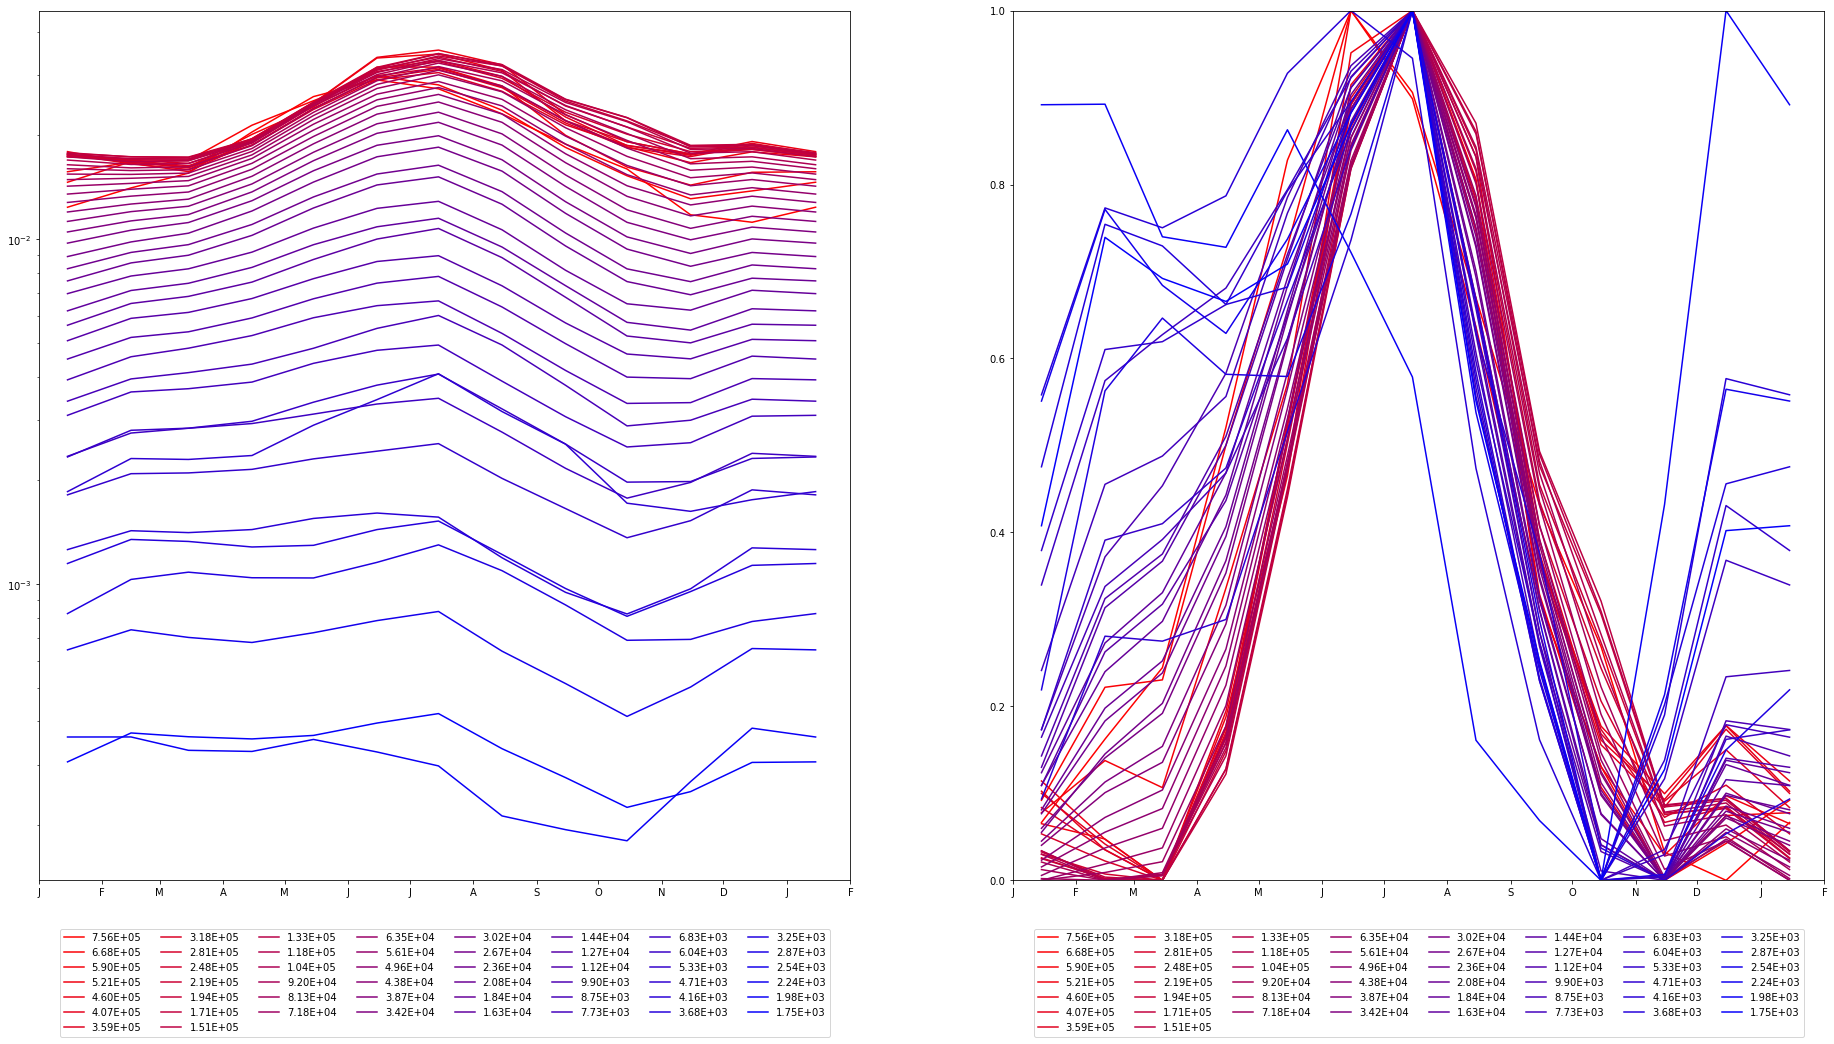

In [130]:
# Plot seasonal cycles KE SF for various rs, in (here do baseline none)
warnings.filterwarnings('ignore');
n = 80
output_seas=m_seas
output_timegroups = list(output_seas.keys())
r = output_seas[output_timegroups[0]].index;
          
peak = 'largest'
if peak == 'earliest': max_ind,max_val = np.inf,-np.inf
if peak == 'largest' : max_ind,max_val = 0     ,-np.inf
for tg in output_timegroups[::+1]:
    _E = output_seas[tg].values
    if peak == 'largest':
        mxind = np.argmax(_E)
        mxval = _E[mxind]
        if mxval  > max_val: max_ind,max_val = mxind,mxval # largest peak
    if peak == 'earliest':
        mxind = argrelextrema(_E, np.greater)[0][0]
        mxval = _E[mxind]
        if mxind < max_ind: max_ind,max_val = mxind,mxval # earliest peak
#     print(max_val,max_ind)

rs                   = np.geomspace( r[max_ind], r[-1], n)
xt                   = np.array([np.datetime64(x) for x in dateutil.rrule.rrule(freq=dateutil.rrule.MONTHLY, count=13, dtstart=datetime.datetime(1, 1, 15))])
rs_nearest, rsn_inds = personal.data_structures.nearest(rs, r)
rsn_inds,valid       = np.unique(rsn_inds,return_index=True)
rs_nearest           = rs_nearest[valid]
seas_keys            = list(seasons.keys()); seas_keys.append(seas_keys[0]) # repeat end for plot continuity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32,16),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
_ax1,_ax2 = axes

for _ax in axes:
    _ax.set_xlim(xmin=np.datetime64('0001-01-01'),xmax=np.datetime64('0002-02-01'))
    _ax.xaxis.set_major_locator(mdates.MonthLocator())
    _ax.xaxis.set_major_formatter( FuncFormatter(lambda x,pos: mdates.DateFormatter('%b')(x)[0] ))
    
lc = len(rsn_inds)+1
cmap_here   = LinearSegmentedColormap.from_list("mycmap", [[1,0,0],[0,0,1]],N=lc)
colors_here = cmap_here(np.linspace(0, 1, lc)[0:lc-1])
for i,ind in enumerate(rsn_inds[::-1]):
    E = np.array([output_seas[seas].values[ind] for seas in seas_keys])
    E[E<0] = np.nan
    _ax1.plot(xt,E,color = colors_here[i], label=f"{r[ind]:.2E}" )
    E_norm = sklearn.preprocessing.minmax_scale(E,feature_range=(0,1),copy=True)
    _ax2.plot(xt,E_norm,color = colors_here[i], label=f"{r[ind]:.2E}" )

_ax1.set_yscale('log')   ; _ax.set_ylim([2e-4, 1.0e-2]);
_ax2.set_yscale('linear');_ax2.set_ylim([0,1])
leg1,leg2 =  _ax1.legend(loc='upper center',ncol=8, bbox_to_anchor=(.5, -0.05)), _ax2.legend(loc='upper center',ncol=8, bbox_to_anchor=(.5, -0.05))

In [54]:
# 3rd order diag SF seasonal... (pray)
data =  kinetic_energy[['u_p','v_p']].sel(baseline="")
velocity_smoothed_rolling_seas_third_order_diagonal_sf = personal.SMODE.calculate_structure_fcn(
    data                    = data, #.to_array().transpose(*('time','variable',...)),
    precomputed             = {},
    save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
    save_filepath           = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'velocity_smoothed_rolling_seas_third_order_diagonal_sf.pkl',
    file_path               = os.path.abspath(os.path.dirname('')),
    data_relpath            = "../Data/LLC4320/",
    output_savepath         = "../Data/LLC4320/smode_region/miscellaneous/",
    metadata                = data,
    random_subset_size      = 4000,
    time_groups             = seas_groups, # how to group the time, can be a list of logical arrays
    nbins                   = 50,
    method_or_order         = '3rd diagonal',
    fill_output_na          = False,
    vectorize               = True,
    parallelize             = True,
    parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
#     parallel_args           = {'n_jobs':20},
    progress_bar            = True,
    ch_size_fcn             = lambda x: 25000,
    value_fcn_parallelize   = True,
    value_fcn_parallel_args = None,
    value_fcn_progress_bar  = True )

_ = gc.collect()

precomputing...
Converting to Dataarray, transposing and reshaping...
getting values from DataArray... 
Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 4000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing



/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:342: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])


Processing: JFM
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 25000 for total length 7998000 -> 320.0 chunks
{'n_jobs': 20}


parallelizing

saving...


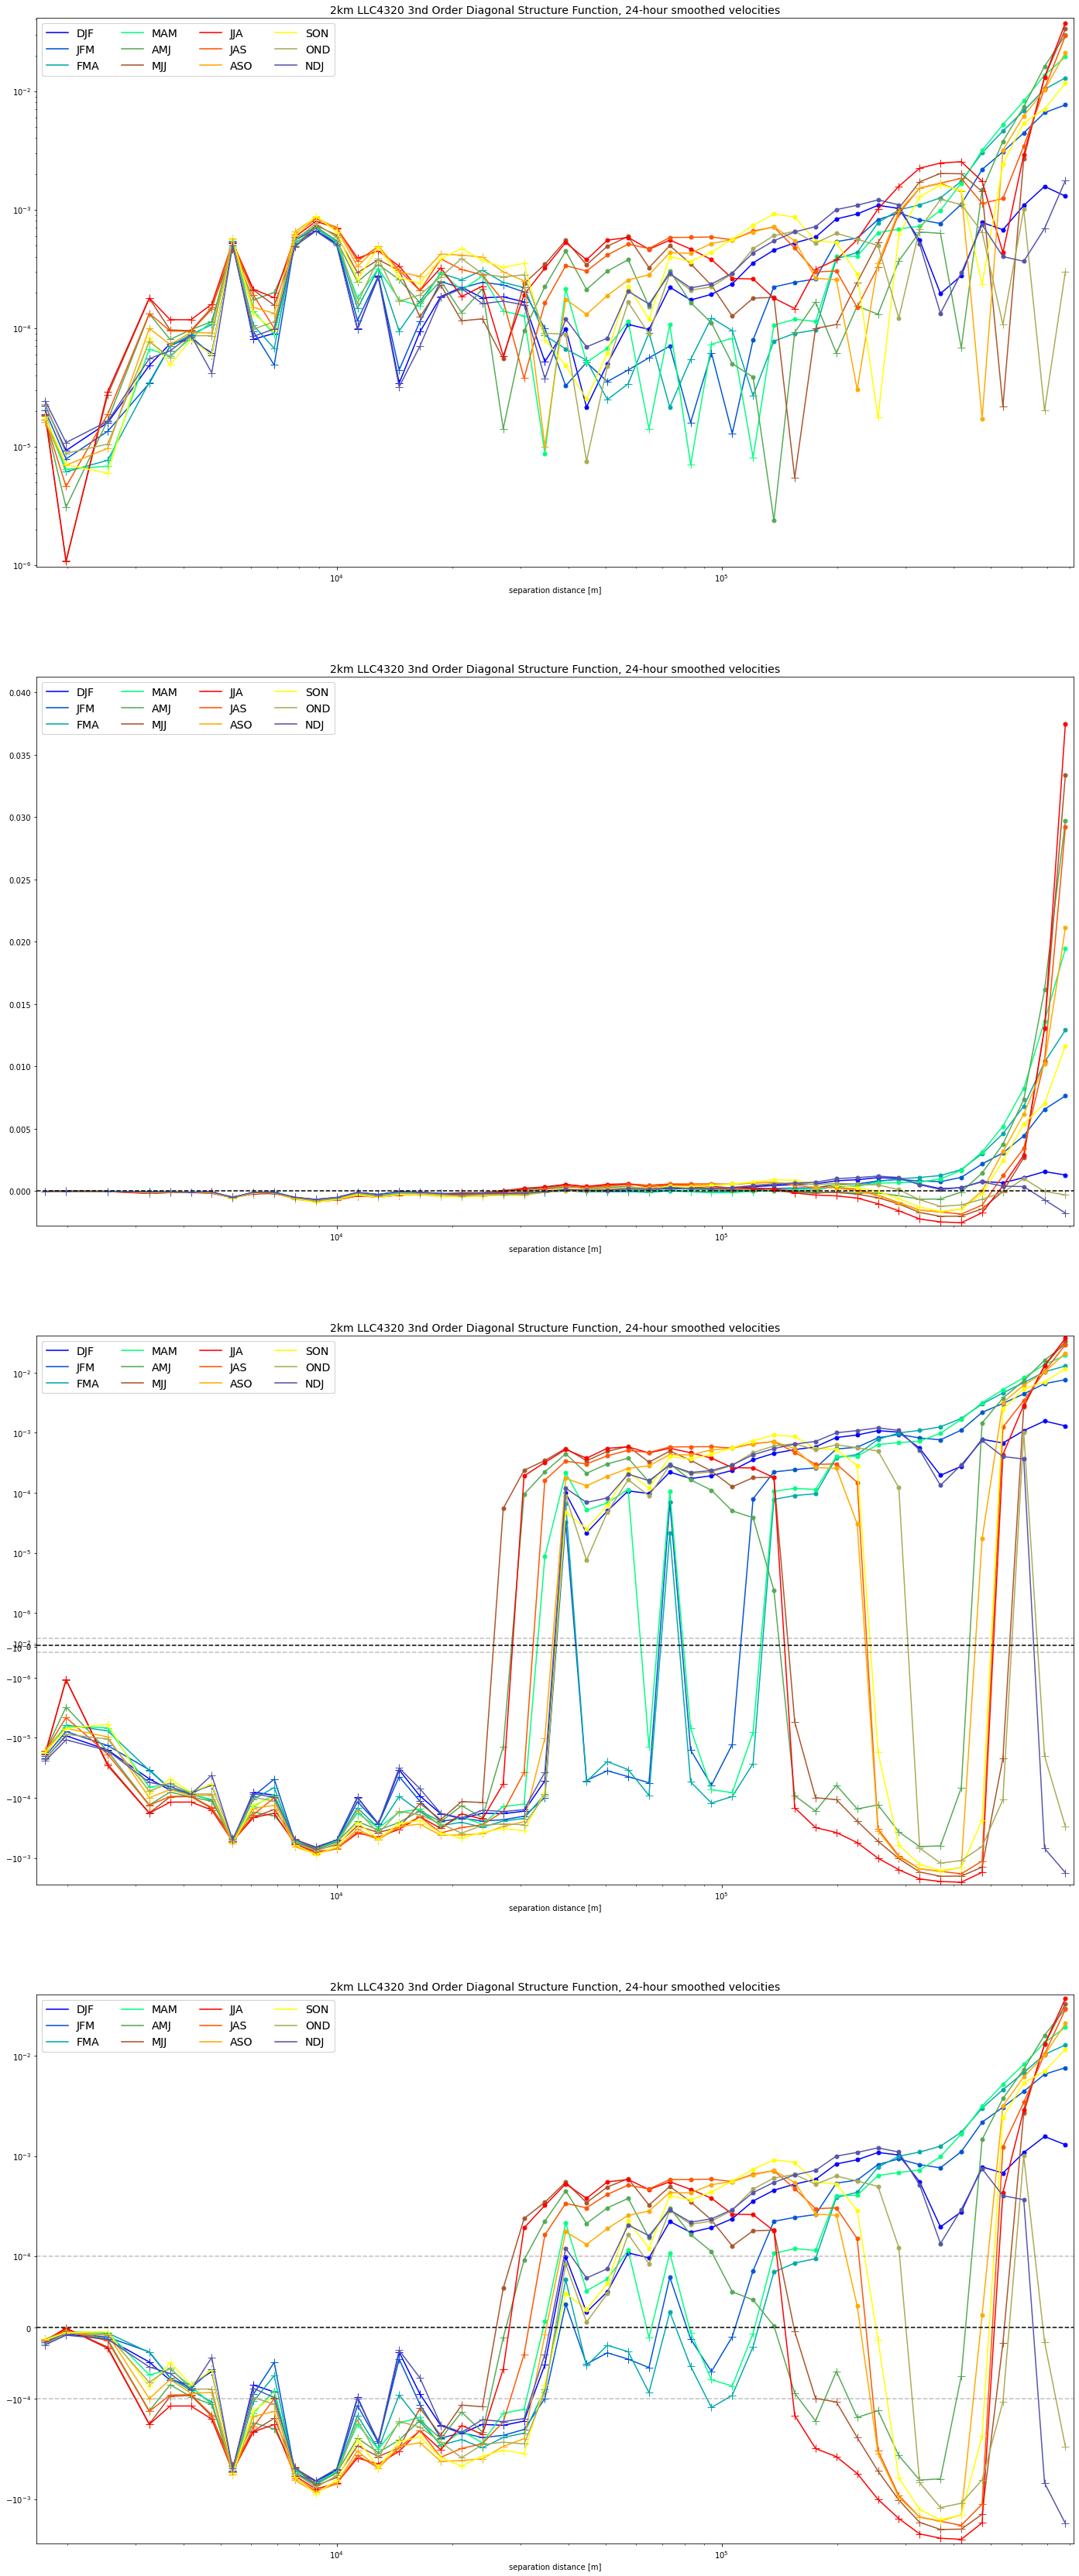

In [13]:
reload(personal.plots)
m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'velocity_smoothed_rolling_seas_third_order_diagonal_sf.pkl')['structure_fcn'] 

cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(24,60),facecolor='white') # height, length 
axes_list = axes.flatten()
scales = ['log', 'linear', 'symlog', 'symlog']
nybounds     = [+np.inf, -np.inf]
nybounds_abs = [+np.inf, -np.inf]
for seas in m_seas.keys():
    n    = m_seas[seas]
    nabs = np.abs(n)
    _nybounds     = personal.math.range_bounds(n.values[~np.isinf(n.values) * ~np.isnan(n.values)])
    _nybounds_abs = personal.math.range_bounds(nabs.values[~np.isinf(nabs.values) * ~np.isnan(nabs.values)])
    
    nybounds      = [ np.minimum(_nybounds[0]    ,nybounds[0]),     np.maximum(_nybounds[1]    ,nybounds[1])     ]
    nybounds_abs  = [ np.minimum(_nybounds_abs[0],nybounds_abs[0]), np.maximum(_nybounds_abs[1],nybounds_abs[1]) ]

for i,_ax in enumerate(axes_list):
    for seas, color in zip(m_seas.keys(),colors):
        n = m_seas[seas]
        if i == 0: nn,n = n,np.abs(n)
        if i == 1: nn,n = n,n
        if i == 2: nn,n = n,n
        if i == 3: nn,n = n,n


        n.dropna().plot(ax=_ax,logx=True,logy='sym',ylim=[np.nanmin(n.values[:]),np.nanmax(n.values[:]) ], style='-',c=color, label=seas)
        n[nn>=0].plot(  ax=_ax,logx=True,logy='sym',ylim=[np.nanmin(n.values[:]),np.nanmax(n.values[:]) ], style='o',c=color,markersize=5, label='_nolegend_',)
        n[nn< 0].plot(  ax=_ax,logx=True,logy='sym',ylim=[np.nanmin(n.values[:]),np.nanmax(n.values[:]) ], style='+',c=color,markersize=10, label='_nolegend_',)

    
    _ax.set_yscale(scales[i])
    ymax = np.max(np.abs(nybounds))
    if i == 2:
        args = personal.plots.calculate_symlog_args(ymax,frac=.02, linthresh_scale=1e-5)
        _ax.axhline( 1*args['linthresh'],color=[.5,.5,.5,.5],linestyle='--')
        _ax.axhline(-1*args['linthresh'],color=[.5,.5,.5,.5],linestyle='--')
    elif i == 3:
        args = personal.plots.calculate_symlog_args(ymax,frac=.2,fixed_linthresh=1e-4)
        _ax.axhline( 1*args['linthresh'],color=[.5,.5,.5,.5],linestyle='--')
        _ax.axhline(-1*args['linthresh'],color=[.5,.5,.5,.5],linestyle='--')
    else:
        args = {}
        
    scale = scales[i]
    _ax.set_yscale(scale, **args)
    if scale != 'log':
        _ax.set_ylim(nybounds * np.power(np.array([1/1.1, 1.1]), np.sign(nybounds)))
    else:
         _ax.set_ylim(np.abs(nybounds_abs) * np.array([.9, +1.1]))

    _ax.set_xlim(nxbounds *.95**np.array([1,-1]))
    
    _ax.axhline(0,linestyle='--',color='k')

    _ax.set_xlabel('separation distance [m]')
    _ax.set_title('2km LLC4320 3nd Order Diagonal Structure Function, 24-hour smoothed velocities',fontsize=14)

    leg  = _ax.get_legend_handles_labels()
    leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='best',ncol=4,fontsize=14)
#     _    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper left' ,ncol=1, fontsize=14)
    _    = _ax.add_artist(leg1)

In [31]:
np.random.choice(np.arange(len(_data_.time)),size=min(20000, len(_data_.time)),replace=False)
# np.random.choice(np.where(np.arange(10))[0], size=11, replace=False)
# np.where(np.arange(10))[0]

array([3738, 4622,  161, ..., 2814, 4088, 3110])

In [25]:
np.random.choice(np.arange(len(_data_.time)),size=min(20000, len(_data_.time)),replace=False)

In [33]:
_ = gc.collect()
client.restart()

Client Scheduler: tcp://127.0.0.1:46636 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.93 GB


In [34]:
del _data_

In [ ]:
# Run all
reload(personal.SMODE)
reload(personal.calculations)
import re
def convert_to_uppercase(m):
    """Convert the second group to uppercase and join both group 1 & group 2"""
    return m.group(1) + m.group(2).upper()

methods      = ['2nd order', '2nd order longitudinal', '2nd order transverse', '3rd order diagonal', '3rd order non-diagonal']
# methods      = ['2nd order longitudinal', '2nd order transverse', '3rd order diagonal', '3rd order non-diagonal']

smoothings   = ['smoothed', '']
baselines    = ['all', '']
time_groups  = {'all':{'all':slice(0,None,None)}, 'rolling seasons':seas_groups, 'by month':mn_groups, 'monthly series':yrmn_groups}

datas        = {'smoothed':kinetic_energy_smoothed, '':kinetic_energy}
styles       = {'2nd order':'normal', '2nd order longitudinal':'normal', '2nd order transverse':'normal', '3rd order diagonal':'symlog wide', '3rd order non-diagonal':'symlog wide'}
slopes       = {'2nd order':[1,(Fraction(1/3), .1)], '2nd order longitudinal':[1,(Fraction(1/3), .1)], '2nd order transverse':[1,(Fraction(1/3), .1)], '3rd order non-diagonal':[], '3rd order non-diagonal':[]}
                
# HFRADAR_2KM_velocity_smoothed_rolling_seas_third_order_diagonal_sf
for i,(method, smoothing, baseline, time_group) in enumerate(itertools.product(methods, smoothings, baselines, time_groups.keys())): # 5 x (2 x 2 x 4) = 5 x (16) = 80
    if i < 0:
        continue
    print(i)
        
    smoothing_name  = smoothing              + ' '   if len(smoothing) > 0      else '' 
    baseline_name   = 'baseline '+ baseline  + ' | ' if len(baseline)  > 0      else '' 
    time_name       = time_group             + ' | ' if time_group is not 'all' else ''
    
    _name_          = 'LLC4320 | ' + smoothing_name +  'velocity | ' + baseline_name + time_name +  method 
    _save_name_     = _name_.replace('| ','').replace(' ','_')
    _plot_title_    = re.sub("(^|\s)(\S)", convert_to_uppercase, _name_)
    _save_filepath_ = os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + _save_name_ + '_sf.pkl'
    print('\n' + _plot_title_ + '\n')
    
    recalc        = True
    plot_output   = True
    if recalc:
        print('calculating')
        _data_         = datas[smoothing][['u_p','v_p']].sel(baseline=baseline)
        if time_group  == 'all':
            sel_inds       = np.sort(np.random.choice(np.arange(len(_data_.time)),size=min(20000, len(_data_.time)),replace=False))
        else:
             # sel_inds       = np.arange(len(_data_.time))
            sel_inds       = np.sort(np.random.choice(np.arange(len(_data_.time)),size=min(30000, len(_data_.time)),replace=False))
        _data_         = _data_.isel(time = sel_inds ).compute()
        ch_size_fcn = lambda data: round(2000 * (max(1,33000/data.shape[2]))**1.0) 


        
        KE_rolling_seas_sf          = personal.SMODE.calculate_structure_fcn(
            data                    = _data_,
            precomputed             = {},
            save_variables          = { 'structure_fcn','distance_bins', 'distance_bin_ranges'}, # save items in this dictionary to given filenames
            save_filepath           = _save_filepath_,
            file_path               = os.path.abspath(os.path.dirname('')),
#             data_relpath            = "../Data/HF_Radar/2km/processed/smode_region/",
#             output_savepath         = "..//Data/HF_Radar/2km/processed/smode_region/miscellaneous/",
            data_relpath            = "../Data/LLC4320/",
            output_savepath         = "../Data/LLC4320/smode_region/miscellaneous/",
            random_subset_size      = 8000,
            time_groups             = {k: (v if not personal.data_structures.isiterable(v) else v[sel_inds]) for k,v in time_groups[time_group].items()}, # how to group the time, can be a list of logical arrays
            nbins                   = 50,
            method_or_order         = method,
            parallelize             = True,
            parallel_args           = {'n_jobs':20, 'require':'sharedmem'},
            ch_size_fcn             = ch_size_fcn,
            load_after_masking      = False,
            load_at_runtime         = False)
        _ = gc.collect()
        
    if plot_output:
        print('plotting')
        _ = personal.calculations.plot_sturucture_function(personal.IO.pickle_load(_save_filepath_)['structure_fcn'], title=_plot_title_, style=styles[method], slopes=slopes[method], leg1_args={'loc':'lower right' ,'ncol':4,'fontsize':10,'facecolor':'white'},titlesize  = 11,
                                                           leg2_args={'loc':'upper left','ncol':6,'fontsize':10,'facecolor':'white'}, save_path = os.path.normpath(os.path.join(file_path, "../Figures/Structure_Function/"))  + '/' + _save_name_ + '_sf.pdf')

    client.restart()


0

LLC4320 | Smoothed Velocity | Baseline All | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
1

LLC4320 | Smoothed Velocity | Baseline All | Rolling Seasons | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
2

LLC4320 | Smoothed Velocity | Baseline All | By Month | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
3

LLC4320 | Smoothed Velocity | Baseline All | Monthly Series | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
4

LLC4320 | Smoothed Velocity | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
5

LLC4320 | Smoothed Velocity | Rolling Seasons | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
6

LLC4320 | Smoothed Velocity | By Month | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
7

LLC4320 | Smoothed Velocity | Monthly Series | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
8

LLC4320 | Velocity | Baseline All | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
9

LLC4320 | Velocity | Baseline All | Rolling Seasons | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
10

LLC4320 | Velocity | Baseline All | By Month | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
11

LLC4320 | Velocity | Baseline All | Monthly Series | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
12

LLC4320 | Velocity | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
13

LLC4320 | Velocity | Rolling Seasons | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
14

LLC4320 | Velocity | By Month | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
15

LLC4320 | Velocity | Monthly Series | 2nd Order

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing



/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])


Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
16

LLC4320 | Smoothed Velocity | Baseline All | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
17

LLC4320 | Smoothed Velocity | Baseline All | Rolling Seasons | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
18

LLC4320 | Smoothed Velocity | Baseline All | By Month | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
19

LLC4320 | Smoothed Velocity | Baseline All | Monthly Series | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
20

LLC4320 | Smoothed Velocity | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting


/export/home1/jbenjami/Research_Thompson/Python/personal/plots.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  def default_figure(**kwargs): return plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi,**kwargs)   # default figure commmand


21

LLC4320 | Smoothed Velocity | Rolling Seasons | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
22

LLC4320 | Smoothed Velocity | By Month | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
23

LLC4320 | Smoothed Velocity | Monthly Series | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing



/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])


Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
24

LLC4320 | Velocity | Baseline All | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
25

LLC4320 | Velocity | Baseline All | Rolling Seasons | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
26

LLC4320 | Velocity | Baseline All | By Month | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
27

LLC4320 | Velocity | Baseline All | Monthly Series | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
28

LLC4320 | Velocity | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
29

LLC4320 | Velocity | Rolling Seasons | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
30

LLC4320 | Velocity | By Month | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
31

LLC4320 | Velocity | Monthly Series | 2nd Order Longitudinal

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
32

LLC4320 | Smoothed Velocity | Baseline All | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
33

LLC4320 | Smoothed Velocity | Baseline All | Rolling Seasons | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
34

LLC4320 | Smoothed Velocity | Baseline All | By Month | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing



/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])


Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
35

LLC4320 | Smoothed Velocity | Baseline All | Monthly Series | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
36

LLC4320 | Smoothed Velocity | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
37

LLC4320 | Smoothed Velocity | Rolling Seasons | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
38

LLC4320 | Smoothed Velocity | By Month | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
39

LLC4320 | Smoothed Velocity | Monthly Series | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
40

LLC4320 | Velocity | Baseline All | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
41

LLC4320 | Velocity | Baseline All | Rolling Seasons | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

Processing: NDJ
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
42

LLC4320 | Velocity | Baseline All | By Month | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 1
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 3
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 4
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 5
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 6
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 7
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 8
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 9
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
43

LLC4320 | Velocity | Baseline All | Monthly Series | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: 2011-12
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: 2012-01
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-02
chunk size: 94828 for total length 31996000 -> 338.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-03
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-04
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-05
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-06
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-07
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-08
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-09
chunk size: 91667 for total length 31996000 -> 350.0 chunks
{'n_jobs': 20}


parallelizing

Processing: 2012-10
chunk size: 88710 for total length 31996000 -> 361.0 chunks
{'n_jobs': 20}


parallelizing

saving...
plotting
44

LLC4320 | Velocity | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: all
chunk size: 8185 for total length 31996000 -> 3910.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



saving...
plotting
45

LLC4320 | Velocity | Rolling Seasons | 2nd Order Transverse

calculating
precomputing...
Converting to Dataarray, loading values, then transposing and reshaping...
getting values from DataArray... Done
masking
calculating coordinates
data valid subset is of length:  86434
taking data subset of length 8000 from data (masked subset) of length 86434
calculating distances
binning
calculating structure function...
Processing: DJF
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing


/export/home1/jbenjami/Research_Thompson/Python/personal/calculations.py:351: RuntimeWarning: invalid value encountered in double_scalars
  struct_fun_info[dst_grp] = np.nansum(np.prod(dg,axis=1)) / np.sum(dg[:,1])



Processing: JFM
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: FMA
chunk size: 30556 for total length 31996000 -> 1048.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MAM
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: AMJ
chunk size: 30220 for total length 31996000 -> 1059.0 chunks
{'n_jobs': 20}


parallelizing

Processing: MJJ
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JJA
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: JAS
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: ASO
chunk size: 29891 for total length 31996000 -> 1071.0 chunks
{'n_jobs': 20}


parallelizing

Processing: SON
chunk size: 45082 for total length 31996000 -> 710.0 chunks
{'n_jobs': 20}


parallelizing

Processing: OND
chunk size: 44355 for total length 31996000 -> 722.0 chunks
{'n_jobs': 20}


In [21]:
_=gc.collect()
personal.system.print_memory_item_sizes(local_items=locals().items(),n=-1,size_fcn=sys.getsizeof)

                      rcParams:  9.1 KiB
                           _i6:  2.7 KiB
                           _i7:  2.7 KiB
                          _i14:  2.3 KiB
                          _i15:  2.2 KiB
                          _i16:  2.2 KiB
                          _i10:  2.2 KiB
                          _i11:  2.2 KiB
                           _i4:  2.2 KiB
                           _i9:  2.2 KiB
                           _i5:  2.2 KiB
                           _i8:  2.2 KiB
                          _i12:  2.2 KiB
                          _i13:  2.2 KiB
                           _i1:  2.2 KiB
                           _i3:  2.2 KiB
                           _i2:  1.8 KiB
                ListedColormap:  1.4 KiB
                 FuncAnimation:  1.0 KiB
                          Axes:  1.0 KiB
                       GeoAxes:  1.0 KiB
                      Fraction:  896.0 B
       LinearSegmentedColormap:  896.0 B
                           _18:  832.0 B
                